# Collaborative Filtering

A popular recommendation system designed by Netflix which recommends items to user based on items that similar users enjoy is called Collaborative Filtering. Usually, value used to compare similarities are ratings provided by users. However, this dataset doesn't have any feedback like that. The most we have is the number of hours on played on each game, which although there isn't the best or direct insight still provides some information about how the user feels towards the game. Since its unclears how to turn play hours into a rating, multiple metrics will be created to act as the rating. 

Different Metrics to replace Rating:
- Raw Hours played
- Sigmoid of Z-score of hours played using user avg and std
- Possion CDF score using game avg and std

It'll also be good to experiment with combining the last two metrics somehow.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.special import expit

dtype_dict_games = {'buyer-count': 'int64',
 'player-count': 'int64',
 'accumulated-hours-played': 'float64',
 'player-frac-of-buyer': 'float64',
 'avg-hours-played': 'float64',
 'std-hours-played': 'float64'}

dtype_dict_users = {'purchased-game-count': 'int64',
 'played-game-count': 'int32',
 'played-hours-count': 'float64',
 'purhased-gametitles-list': 'object',
 'played-gametitles-list': 'object',
 'percent-library-played': 'float64',
 'played-hours-avg': 'float64',
 'played-hours-std': 'float64',
 'played-hours-max': 'float64',
 'most-played-game': 'object'}

games_stats_df = pd.read_csv('./steam_game_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_games)
users_stats_df = pd.read_csv('./steam_user_aggregate_data.CSV', index_col= 0,dtype=dtype_dict_users)

## 1. Raw Hours Played

The original data is going to be needed to loop through and insert values into a sparse matrix. The matrix we're making will contain the information associated to a user's opinion of a game. Since most of the cells will be empty, it makes sense to loop through the played_df we made in an earlier notebook.

In [2]:
#names to assign to columns
column_names = ['user-id','game-title','behavior-name','value']

#dtypes to assign
dtypes = {'user-id':int, 'game-title':str, 'behavior-name':'category', 'value':np.float64}

#read in data from csv (please adjust path if you want to run this). Dropped last column because useless
df = pd.read_csv('./steam-200k.csv', 
                usecols=[0,1,2,3],
                names=column_names)

play_mask = df['behavior-name'] == 'play'
play_df = df[play_mask]

The next cell creates a large empty dataframe that the size of (#ofUsers)x(#ofGames).

In [85]:
full_game_list = games_stats_df.index.to_list()
full_user_list = users_stats_df.index.to_list()
hours_played_matrix = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

Going through every recording of hours played on each game, we insert the number of hours into each cell accordingly

In [87]:
for ind, row in play_df.iterrows():
    hours_played_matrix.at[int(row['user-id']), row['game-title']] = row['value']    

Next, cosine similarity is going to be calculated using a function in the scikit-learn machine learning library. This accepts sparse arrays created using scipy's csr_matrix() function (i.e, CSR = Compress Sparse Row)

In [94]:
hours_played_matrix_sparse = sparse.csr_matrix(hours_played_matrix.fillna(0).values.T)

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(hours_played_matrix_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)

We're going to see what are the recommendation for popular valve game, 'Team Fortress 2".

In [103]:
similarity_df['Team Fortress 2'].sort_values(ascending=False)

Team Fortress 2                                   1.000000
Poker Night at the Inventory                      0.166778
Thief Town                                        0.140406
Eidolon                                           0.140406
Super Game Jam                                    0.140406
                                                    ...   
Planetside 2 Elite Soldier Bundle                 0.000000
Planets Under Attack                              0.000000
Planetary Annihilation - Original Soundtrack      0.000000
Planetary Annihilation - Digital Deluxe Bundle    0.000000
007 Legends                                       0.000000
Name: Team Fortress 2, Length: 5155, dtype: float64

The recommendation system didn't work well, but this is likely because raw hours were used instead of standardized values. Below a histogram of the hours values are shown, showing a deep skew right.

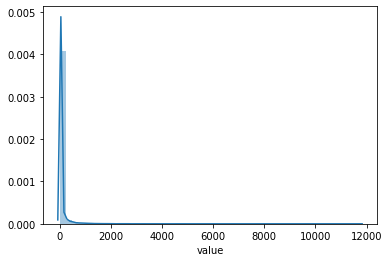

In [102]:
import seaborn as sns

sns.distplot(play_df['value'])

## Sigmoid or Z-Scores (Calculated with User statistics)

This next method is going to use a sigmoid function because we want to map a domain of [0,$\infty$) to a domain of [0,1]. However, the middle score is at ln2(=0.693) hours, when it'd be better to have it at the mean hours that the user typical plays games.

The idea here is if a user spent more time than they usually do playing game, they "must" have liked it, while a game that they quit quickly wasn't meant for them. The biggest short coming is that there are some games are designed to be beat in a short amount of time, but users would still rate the game well dispite the short playtime.

In [143]:
def zScore(val, mean, std):
    return (val-mean)/std

def zigmoid(row):
    user_stats = users_stats_df.loc[row['user-id']]
    mean = user_stats['played-hours-avg']
    std = user_stats['played-hours-std']
    return expit(zScore(row['value'], mean, std))

In [144]:
hours_played_matrix_zig = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    hours_played_matrix_zig.at[int(row['user-id']), row['game-title']] = zigmoid(row)

C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [171]:
for ind, row in hours_played_matrix_zig.iterrows():
    impute_mean = users_stats_df['played-hours-avg'][ind]
    row.fillna(impute_mean, inplace=True)

In [176]:
hours_played_matrix_zig_sparse = sparse.csr_matrix(hours_played_matrix_zig.values.T)

In [161]:
#games_stats_df.loc[play_df.iloc[1]['game-title']]

similarities = cosine_similarity(hours_played_matrix_zig_sparse)

similarity_df = pd.DataFrame(similarities, columns=full_game_list, index=full_game_list)

In [167]:
similarity_df["Broforce"].sort_values(ascending=False)

Broforce                           1.000000
Little Inferno                     0.999927
Gang Beasts                        0.999918
Grow Home                          0.999916
Pat & Mat                          0.999916
                                     ...   
Garry's Mod                        0.992230
The Elder Scrolls V Skyrim         0.989400
Team Fortress 2                    0.984095
Dota 2                             0.980004
Counter-Strike Global Offensive    0.979062
Name: Broforce, Length: 5155, dtype: float64

# Possion CDF (Calculated with Game Statistics)

In [135]:
from scipy.stats import poisson

def possionCDFScore(row):
    user_stats = users_stats_df.loc[row['user-id']]
    mean = user_stats['avg-hours-played']
    return poisson(row['value'], mean)

In [136]:
hours_played_matrix_pos = pd.DataFrame(columns=full_game_list, index=full_user_list, dtype=np.float64)

for ind, row in play_df.iterrows():
    hours_played_matrix_pos.at[int(row['user-id']), row['game-title']] = possionCDFScore(row)

KeyError: 'avg-hours-played'